Problem 3: Normal distribution for stock returns

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wrds
import seaborn as sns
import scipy.stats as ss
import scipy.integrate as integrate
import scipy.special as special

from tabulate import tabulate
from scipy.stats import norm

In [2]:
#db = wrds.Connection(wrds_username='anita97')
#db.create_pgpass_file()

In [3]:
company = {"aapl": 7, "gs": 35048, "msft": 8048, "pg": 21446, "ge": 20792} 
company_names = ["Apple", "Goldman Sachs", "Microsoft", "P&G", "General Eletrics"]

ind = pd.date_range(start="01-01-2001", end="31-12-2018", freq="D") #201999999
df = pd.DataFrame(index=ind)

In [4]:
'''
for key,value in company.items(): # import data for all companies in csv file
    rets = db.raw_sql(f"select date, ret from crsp.dsf where permco in ({value}) and date>='1999-12-31' and date<='2019-12-31'").set_index("date").rename(columns={"ret":key})
    df = pd.merge(df, rets, left_index=True, right_index=True)
    df.to_csv('as2_ex3_data.csv')
'''

'\nfor key,value in company.items(): # import data for all companies in csv file\n    rets = db.raw_sql(f"select date, ret from crsp.dsf where permco in ({value}) and date>=\'1999-12-31\' and date<=\'2019-12-31\'").set_index("date").rename(columns={"ret":key})\n    df = pd.merge(df, rets, left_index=True, right_index=True)\n    df.to_csv(\'as2_ex3_data.csv\')\n'

In [5]:
wrds_df = pd.read_csv('as2_ex3_data.csv', index_col=0) # read the file
wrds_df.index = pd.to_datetime(wrds_df.index)

a) For each stock compute the mean and variance of daily simple returns

In [6]:
mean = []
var = []
print('We are working with daily simple returns: \n\n')
for company in wrds_df.columns:
    rets = wrds_df[company] # data for each company
    i = wrds_df.columns.get_loc(company) # index
    company_name = company_names[i] # name of that company
    
    mean.append(rets.mean()) # mean
    var.append(rets.var()) # variance

    print('%s: \n' %company_name)
    print('mean = %.5f variance = %.5f \n\n' % (mean[len(mean)-1], var[len(var)-1]))

We are working with daily simple returns: 


Apple: 

mean = 0.00140 variance = 0.00053 


Goldman Sachs: 

mean = 0.00039 variance = 0.00050 


Microsoft: 

mean = 0.00059 variance = 0.00032 


P&G: 

mean = 0.00036 variance = 0.00013 


General Eletrics: 

mean = -0.00010 variance = 0.00037 




b) Plot the empirical density function of stock returns and compare 

1) to the normal distribution with
the same mean and variance as the empirical distribution 

2) the normal
distribution with mean and variance of the `winsorized' empirical distribution.

Apple: 



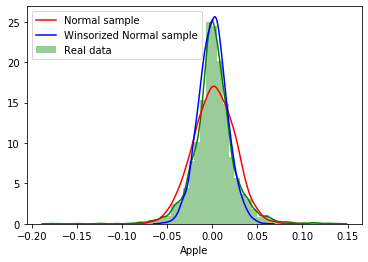




Goldman Sachs: 



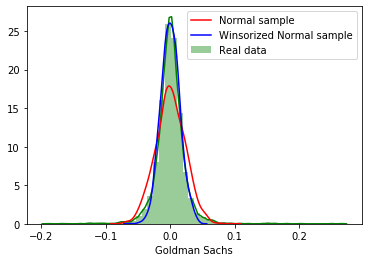




Microsoft: 



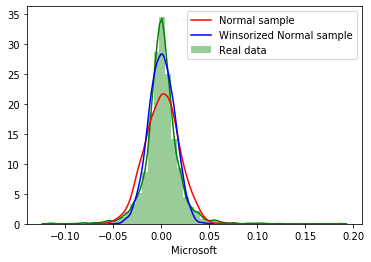




P&G: 



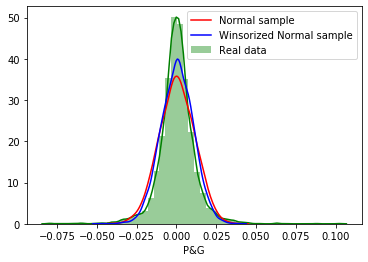




General Eletrics: 



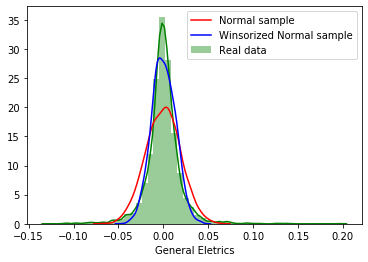

In [22]:
normal_sample = [None]*len(company_names)
for company in wrds_df.columns:
    rets = wrds_df[company] # data for each company
    i = wrds_df.columns.get_loc(company) # index
    company_name = company_names[i] # name of that company

    # 1) creation of a normale sample with fixed mean and variance
    mu = mean[i]
    sigma = np.sqrt(var[i])
    lenght = len(rets) # lenght of the normal sample
    normal_sample[i] = pd.Series(np.random.normal(mu, sigma, lenght)) # ss.norm.pdf 

    #2)
    # compute the `winsorized' empirical distribution, simply keep only the daily returns with absolute value less than 4%
    property_wins = rets.between(-0.04, 0.04) # boolean vector
    rets_wins = rets[property_wins] # drop false elements (not absolute value less than 4%)
    mu_wins = rets_wins.mean()
    sigma_wins = rets_wins.std()
    # creation of a normale sample with fixed mean_wins and sigma_wins
    lenght_wins = len(rets_wins) # lenght of the normal sample
    normal_sample_wins = pd.Series(np.random.normal(mu_wins, sigma_wins, lenght_wins))

    # plot (using seaborn)
    print('%s: \n' %company_name)
    plt.figure()
    sns.distplot(rets, axlabel=company_name, color='g', label='Real data')
    sns.kdeplot(normal_sample[i], color='r', label='Normal sample')
    sns.kdeplot(normal_sample_wins, color='b', label='Winsorized Normal sample')
    plt.legend()
    plt.show()
    print('\n\n')

    


(c) For each stock, 

part a) compute the 95% and 99% Value-at-Risk and Conditional Expected  Shortfall from the empirical distribution of returns, 

part b) and compare to the Value-at-Risk and Conditional Expected Shortfall 

that would obtain if the distributions were normal with corresponding means and variances.

References to theory:  
A value-at-risk measure calculates an amount of money such that there is that probability of the portfolio not loosing more than that amount of money over that time horizon. In the terminology of mathematics, this is called a quantile, so one-day 90% USD VaR is just the 90% quantile of a portfolio’s one day loss in US dollars.

Quantile = 


In [43]:
for company in wrds_df.columns:
    rets = wrds_df[company]
    #q quantile leaves to its left the q percent of elements
    i = wrds_df.columns.get_loc(company) # index
    company_name = company_names[i] # name of that company

    # VaR: if we want VaR 99%, it means that we want l such that P(loss>l)=0.99, so we want P(loss<l)=1-p, so the quantile of 1-0.99
    def compute_variance (data,p): # function which calculate th VaR of a set of 'data' at a percentage 'p'
       return data.quantile(1-p)
    
# part a) 
    # VaR
    var_95 = compute_variance(rets,0.95) 
    var_99 = compute_variance(rets,0.99)

    
    # ES (x; p) = 1/p * integrate between 0 and p of {var(x;y)dy}
    def compute_es (data,p):
        result_integrate = integrate.quad(lambda y: compute_variance(data,y), 0, p) 
        # integrate function is really low. TO make it faster we could approximate the solution using a discrete sum
        
        return result_integrate[0]/p

    # ES
    es_95 = compute_es(rets,0.95) 
    es_99 = compute_es(rets,0.99)
    
# part b) if the distributions were normal
    # VaR_norm
    #var_95_norm = compute_variance(normal_sample[i],0.95) 
    var_95_norm = ss.norm.ppf(1-0.95,mean[i],np.sqrt(var[i]))

    #var_99_norm = compute_variance(normal_sample[i],0.99)
    var_99_norm = ss.norm.ppf(1-0.99,mean[i],np.sqrt(var[i]))

    def compute_es_norm (mu,std,p):
        result_integrate = integrate.quad(lambda y: ss.norm.ppf(1-y,mu,std) , 0, p) 
        return result_integrate[0]/p

    # ES_norm
    es_95_norm = compute_es_norm (mean[i],np.sqrt(var[i]),0.95)
    es_99_norm = compute_es_norm (mean[i],np.sqrt(var[i]),0.99)

    # print the results
    print('%s:' %company_name)
    table = [['95%', var_95, es_95, var_95_norm, es_95_norm],['99%', var_99, es_99, var_99_norm, es_99_norm]] # creation of the table to print
    print(tabulate(table, headers=['Percentage Level','Empirical VaR','Empirical ES', 'Normal VaR','Normal ES']))
    print('\n')


Apple:
Percentage Level      Empirical VaR    Empirical ES    Normal VaR    Normal ES
------------------  ---------------  --------------  ------------  -----------
95%                      -0.0344095      0.00411676    -0.0365907   0.00390645
99%                      -0.0575896      0.00220559    -0.0523306   0.00202082


Goldman Sachs:
Percentage Level      Empirical VaR    Empirical ES    Normal VaR    Normal ES
------------------  ---------------  --------------  ------------  -----------
95%                      -0.0322079      0.0030133     -0.036501   0.00282566
99%                      -0.0567715      0.00124572    -0.0517859  0.000994541


Microsoft:
Percentage Level      Empirical VaR    Empirical ES    Normal VaR    Normal ES
------------------  ---------------  --------------  ------------  -----------
95%                      -0.0265687      0.00274262    -0.0288651   0.00253901
99%                      -0.0493937      0.00125925    -0.0410708   0.00107677


P&G:
Percentag